In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = 10, 6

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [137]:
from dateutil.relativedelta import relativedelta

In [3]:
!cd

C:\Users\Starl\Documents\William Project\Machine Learning


## Load Data

In [19]:
df = pd.read_csv("Datasets/time_series_data/shampoo.csv")

In [20]:
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [21]:
df["date"] = pd.to_datetime("190" + df["Month"])
df.set_index("date", drop=True, inplace=True)

In [22]:
df.drop("Month", axis=1, inplace=True)

In [23]:
df.head()

,Sales
date,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


In [24]:
df.reset_index().describe(include="all").T

C:\Users\Starl\AppData\Local\Temp/ipykernel_33524/3571952871.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.reset_index().describe(include="all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date,36,36,1901-01-01,1,1901-01-01,1903-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sales,36.0,NaN,NaT,NaN,NaT,NaT,312.6,148.937164,119.3,192.45,280.15,411.1,682.0


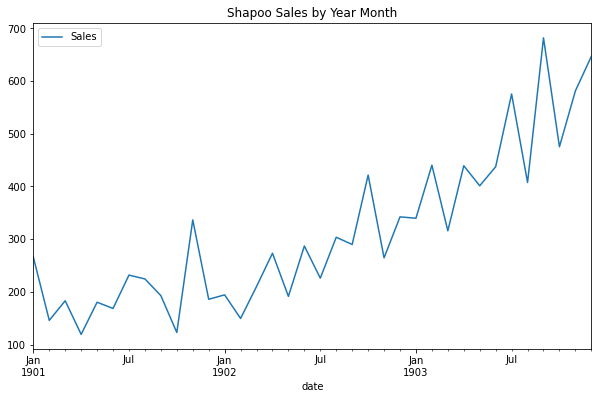

In [26]:
df.plot.line()
plt.title("Shapoo Sales by Year Month")
plt.show()

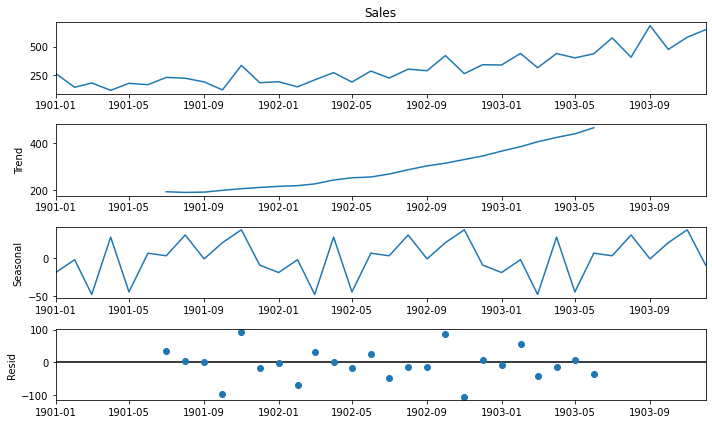

In [51]:
decomp = seasonal_decompose(df["Sales"])
fig = decomp.plot()

## Check Stationary

In [31]:
def adf_test(time_series):
    """Augmented Dicky-Fuller Test result explain. 
    Null hypothesis: The time series is not stationary"""
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', "p-value", "# of lags", "Num of Observations used"]
    
    for value, label in zip(result, labels):
        print(label+ " : "+str(value))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print("Reject null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root and is non-stationary")

In [32]:
adf_test(df)

Augmented Dicky-Fuller Test
ADF Test Statistic : 3.060142083641182
p-value : 1.0
# of lags : 10
Num of Observations used : 25
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non-stationary


In [37]:
# calculate difference
first_difference = df["Sales"].diff().dropna()

In [41]:
# Stationary Test on differences
adf_test(first_difference)

Augmented Dicky-Fuller Test
ADF Test Statistic : -7.249074055553852
p-value : 1.799857414168716e-10
# of lags : 1
Num of Observations used : 33
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


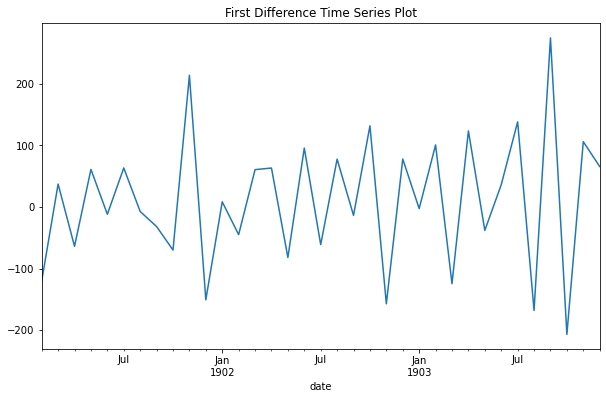

In [44]:
first_difference.plot.line()
plt.title("First Difference Time Series Plot")
plt.show()

## Plot ACF and PACF

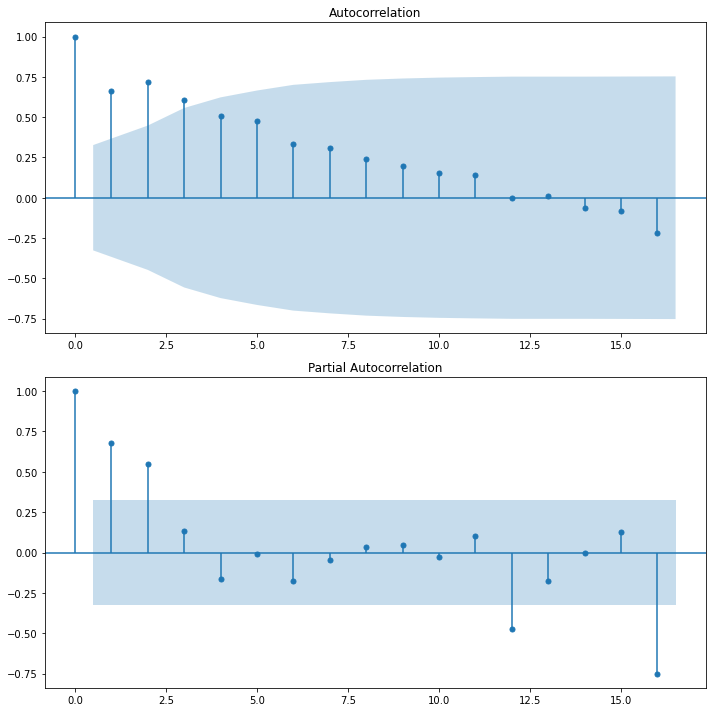

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
plot_acf(df["Sales"], ax=ax[0])
plot_pacf(df["Sales"], ax=ax[1])
plt.tight_layout()
plt.show()

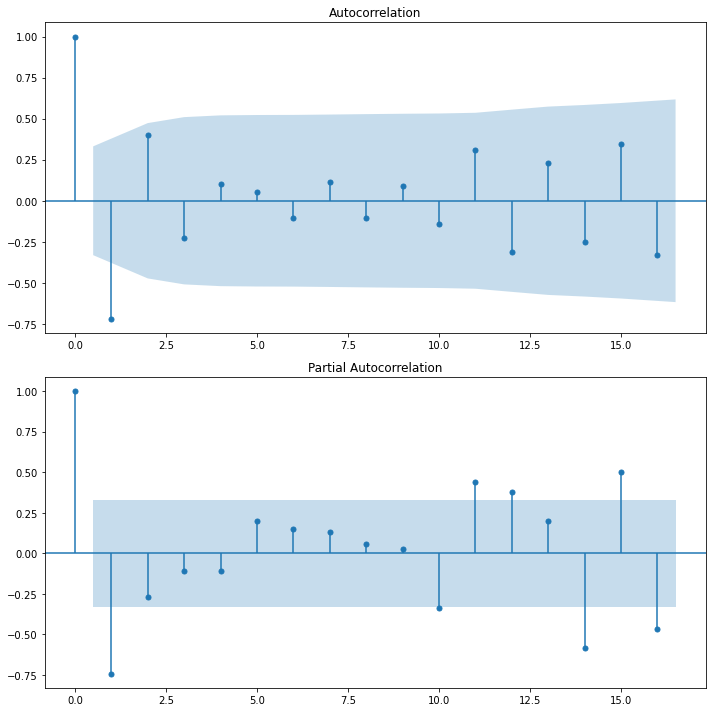

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
plot_acf(first_difference, ax=ax[0])
plot_pacf(first_difference, ax=ax[1])
plt.tight_layout()
plt.show()

Based on the ACF and PACF, we can try to ARIMA model with order(0, 1, 1).
Or SARIMA model with order(0, 1, 0) and seasonal order (0, 1, 1, 12).

## Model Training - ARIMA

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [55]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [118]:
X_train = df.loc["1901-01-01":"1903-06-01", "Sales"]
y_validation = df.loc["1903-07-01":"1903-12-01", "Sales"]

In [119]:
# ARIMA model
arima = ARIMA(X_train, order=(0, 1, 1))
arima_fit = arima.fit()

D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [171]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   30
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -163.805
Date:                Sun, 13 Mar 2022   AIC                            331.610
Time:                        23:29:50   BIC                            334.344
Sample:                    01-01-1901   HQIC                           332.466
                         - 06-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6351      0.172     -3.683      0.000      -0.973      -0.297
sigma2      4639.5161   1254.565      3.698      0.000    2180.613    7098.419
Ljung-Box (L1) (Q):                   3.02   Jarque-

In [120]:
# y_forecast = arima_fit.predict(start="1903-07-01", end="1903-12-01")
y_forecast = arima_fit.forecast(steps=6)

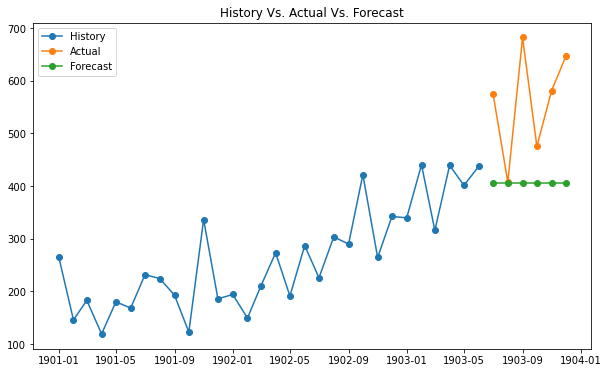

In [121]:
plt.plot(X_train.index, X_train, label="History", marker="o")
plt.plot(y_validation.index, y_validation, label="Actual", marker="o")
plt.plot(y_validation.index, y_forecast, label="Forecast", marker="o")
plt.legend()
plt.title("History Vs. Actual Vs. Forecast")
plt.show()

In [122]:
print("RMSE: ", mean_squared_error(y_validation, y_forecast) ** 0.5)
print("MAPE: ", mean_absolute_percentage_error(y_validation, y_forecast))

RMSE:  181.37643907064594
MAPE:  0.25274145848070156


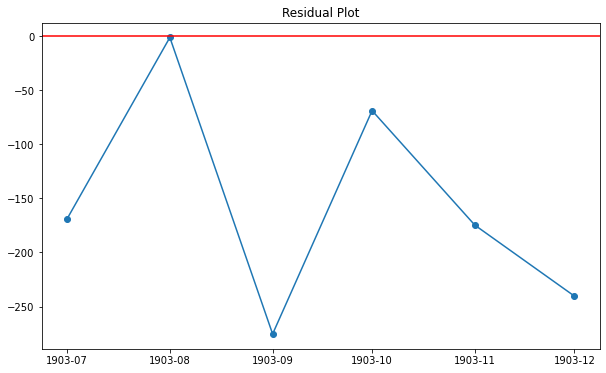

In [124]:
residuals = y_forecast - y_validation
plt.plot(residuals.index, residuals, marker='o')
plt.axhline(0, c='r')
plt.title("Residual Plot")
plt.show()

## Model Training - SARIMA

In [203]:
# SARIMA model
# sarima = SARIMAX(X_train, order=(0, 1, 0), seasonal_order=(0, 1, 1, 12))
sarima = SARIMAX(X_train, order=(0, 1, 1), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima.fit()

D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [204]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   30
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -103.770
Date:                             Sun, 13 Mar 2022   AIC                            211.539
Time:                                     23:34:08   BIC                            213.206
Sample:                                 01-01-1901   HQIC                           211.705
                                      - 06-01-1903                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7447      0.166     -4.478      0.000      -1.071      -0.419
sigma2      1.122e+04   3837.271      2.925      0.003    3703.355    1.87e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.08   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.02   Prob(JB):                         0.78
Heteroskedasticity (H):               1.01   Skew:                            -0.28
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [205]:
y_forecast=sarima_fit.forecast(steps=6)

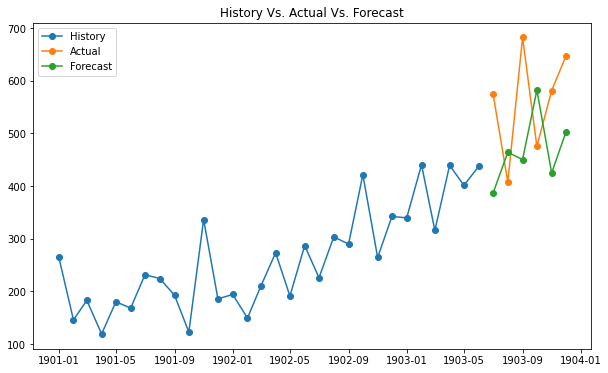

In [206]:
plt.plot(X_train.index, X_train, label="History", marker="o")
plt.plot(y_validation.index, y_validation, label="Actual", marker="o")
plt.plot(y_validation.index, y_forecast, label="Forecast", marker="o")
plt.legend()
plt.title("History Vs. Actual Vs. Forecast")
plt.show()

In [207]:
print("RMSE: ", mean_squared_error(y_validation, y_forecast) ** 0.5)
print("MAPE: ", mean_absolute_percentage_error(y_validation, y_forecast))

RMSE:  157.7184333857732
MAPE:  0.25385314563348454


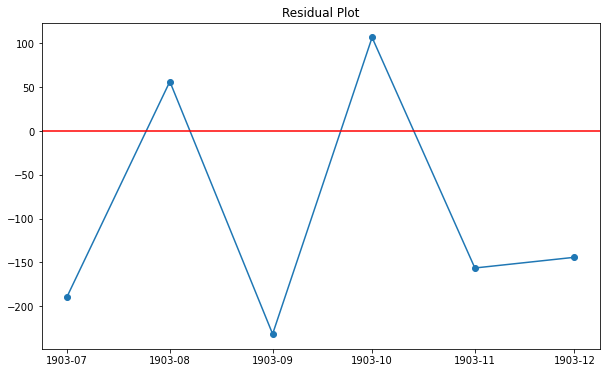

In [208]:
residuals = y_forecast - y_validation
plt.plot(residuals.index, residuals, marker='o')
plt.axhline(0, c='r')
plt.title("Residual Plot")
plt.show()

## Rolling Forecast

In [214]:
rolling_predictions = []
for train_end in y_validation.index:
    train_data = df.loc[:train_end-relativedelta(months=1), "Sales"]
    model = SARIMAX(train_data, order=(0,1,1), seasonal_order=(0,1,0,12))
    model_fit = model.fit()
    
    pred = model_fit.forecast()[0]
    rolling_predictions.append(pred)

D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Apps\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency

In [215]:
rolling_predictions

[386.4121131133706,
 520.3075608734997,
 471.165237059358,
 661.9440284719941,
 452.05173751926503,
 560.2896080017562]

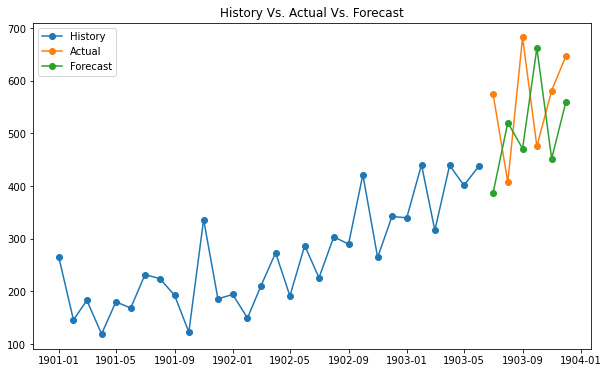

In [216]:
plt.plot(X_train.index, X_train, label="History", marker="o")
plt.plot(y_validation.index, y_validation, label="Actual", marker="o")
plt.plot(y_validation.index, rolling_predictions, label="Forecast", marker="o")
plt.legend()
plt.title("History Vs. Actual Vs. Forecast")
plt.show()

In [217]:
print("RMSE: ", mean_squared_error(y_validation, rolling_predictions) ** 0.5)
print("MAPE: ", mean_absolute_percentage_error(y_validation, rolling_predictions))

RMSE:  159.13882159411116
MAPE:  0.2771892224874472


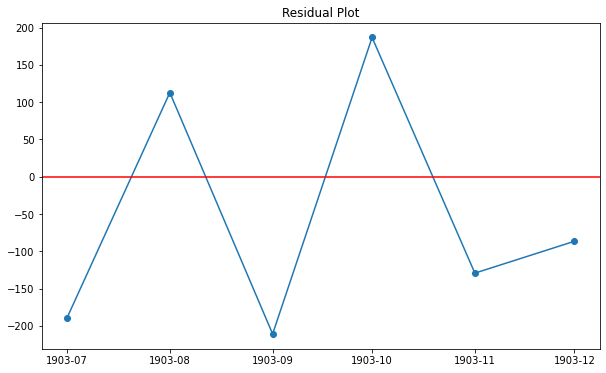

In [218]:
residuals = rolling_predictions - y_validation
plt.plot(residuals.index, residuals, marker='o')
plt.axhline(0, c='r')
plt.title("Residual Plot")
plt.show()